In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from atusfunclib import load_data
from activitylib import ACTINFO
import wlmetrics as wlm
import pickle
from datetime import date
from scipy.stats import gaussian_kde

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics
from sklearn.externals import joblib
from sklearn import base

In [5]:
from modellib import compute_mse, BaseResEnsembleEstimator, DataFrameSelector, EstimatorTransformer, ImputeNumber

In [6]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [7]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [8]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [9]:
# Split by weekday and weekend/holiday
df_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)]
df_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)]

In [10]:
del df

In [11]:
df_wehol.head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,t09_W,t10_W,t11_W,t12_W,t13_W,t14_W,t15_W,t16_W,t18_W,t50_W
1,20030100013344,41,2,2003,0,7,2.0,NaN,30.0,1,...,0.0,0.0,1.561790e+08,1.023840e+09,0.0,0.0,0.0,0.000000e+00,3.470645e+07,0.0
2,20030100013352,26,2,2003,0,7,1.0,NaN,12.0,2,...,0.0,0.0,2.872896e+08,1.302379e+09,0.0,0.0,0.0,2.298316e+08,3.830527e+07,0.0
8,20030100014550,33,2,2003,0,7,2.0,NaN,40.0,1,...,0.0,0.0,1.069807e+08,1.833956e+08,0.0,0.0,0.0,0.000000e+00,4.584889e+07,0.0
10,20030100014928,26,1,2003,0,7,1.0,NaN,57.0,1,...,0.0,0.0,2.942223e+07,2.353779e+08,0.0,0.0,0.0,0.000000e+00,1.196504e+08,0.0
11,20030100015106,33,2,2003,0,1,1.0,NaN,35.0,1,...,0.0,0.0,3.536591e+07,8.841477e+07,0.0,0.0,0.0,0.000000e+00,4.294432e+07,0.0


In [12]:
df_weday.head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,t09_W,t10_W,t11_W,t12_W,t13_W,t14_W,t15_W,t16_W,t18_W,t50_W
0,20030100013280,60,1,2003,0,6,1.0,NaN,30.0,2,...,0.0,0.0,4.077731e+07,2.650525e+09,1.631093e+09,0.000000e+00,0.0,0.0,0.000000e+00,0.0
3,20030100013848,36,2,2003,0,5,2.0,NaN,NaN,4,...,0.0,0.0,1.655506e+08,1.754836e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0
4,20030100014165,51,1,2003,0,5,2.0,NaN,80.0,1,...,0.0,0.0,2.822916e+08,1.841032e+08,1.841032e+08,0.000000e+00,0.0,0.0,2.393342e+08,0.0
5,20030100014169,32,2,2003,0,5,2.0,NaN,40.0,2,...,0.0,0.0,2.246026e+08,1.053905e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0
6,20030100014209,44,2,2003,0,2,1.0,NaN,52.0,1,...,0.0,0.0,1.555935e+08,0.000000e+00,0.000000e+00,3.275653e+06,0.0,0.0,8.352914e+07,0.0


In [13]:
# Weights for ratio calculation
weights_p = np.array([0.1, 0.2, 1.0, 0.6, 0.6, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.2])
weights_n_occ = np.array([0.0, 1.0, 0.8, 1.0])
weights_n_hom = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8])

In [14]:
# Calculate metrics (i.e. y data)
df_weday_y = pd.DataFrame()
df_wehol_y = pd.DataFrame()

# Weekday
df_weday_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_weday_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_weday_y['metric3'] = wlm.w_l_balance_personalcare(df_weday)
df_weday_y['metric4'] = wlm.w_l_balance_leisuresocial(df_weday)

df_weday_y['metric5'] = wlm.w_l_balance_workday(df_weday, workid='0501', hours=9)
df_weday_y['metric6'] = wlm.w_l_balance_housework(df_weday, hours=4)

# Weekend/holiday
df_wehol_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_wehol_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_wehol_y['metric3'] = wlm.w_l_balance_personalcare(df_wehol)
df_wehol_y['metric4'] = wlm.w_l_balance_leisuresocial(df_wehol)

df_wehol_y['metric5'] = wlm.w_l_balance_workday(df_wehol, workid='0501', hours=9)
df_wehol_y['metric6'] = wlm.w_l_balance_housework(df_wehol, hours=4)

In [15]:
df_weday_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
0,0.713028,0.682509,0.031250,0.364583,False,False
3,0.589085,0.479548,0.041667,0.184028,False,True
4,0.405106,0.491040,0.115972,0.083333,False,False
5,0.649472,0.471952,0.069444,0.211806,False,True
6,0.365951,0.427464,0.082639,0.001389,False,False


In [16]:
df_wehol_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
1,0.759298,0.734520,0.104167,0.409722,False,False
2,0.665614,0.570107,0.107639,0.236111,False,True
8,0.589298,0.448221,0.100694,0.083333,False,True
10,0.308947,0.558185,0.052083,0.083333,True,False
11,0.603684,0.558897,0.076389,0.121528,False,False


In [17]:
# Features list
features = ['TEAGE', 'TESEX', 'GEMETSTA', 'GESTFIPS',
            'TELFS', 'TRDPFTPT',
            'TRSPPRES', 'TESPEMPNOT',
            'TESCHENR', 'PEEDUCA',
            'PTDTRACE',
            'TRCHILDNUM', 'TRNUMHOU',
            'TRDTOCC1', 'TEIO1COW', 'TRERNWA']

catfeatures = ['GEMETSTA', 'GESTFIPS',
               'TELFS', 'TRDPFTPT',
               'TRSPPRES', 'TESPEMPNOT',
               'TESCHENR',
               'PTDTRACE',
               'TRDTOCC1', 'TEIO1COW']

In [18]:
# Features matrix (i.e. X data)
df_weday_X = df_weday[features]
df_wehol_X = df_wehol[features]

In [19]:
# Split train-test indices
rs = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

train_wd, test_wd = rs.split(df_weday).next()
train_wh, test_wh = rs.split(df_wehol).next()

In [20]:
del df_weday
del df_wehol

In [23]:
df_weday_X[['TESEX', 'TEAGE', 'PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU', 'GEMETSTA', 'GESTFIPS']].head()

,TESEX,TEAGE,PEEDUCA,TRERNWA,TRCHILDNUM,TRNUMHOU,GEMETSTA,GESTFIPS
0,1,60,44,660.0,0,3,1.0,6
3,2,36,39,NaN,2,4,2.0,13
4,1,51,45,NaN,2,4,2.0,21
5,2,32,43,576.0,1,3,2.0,21
6,2,44,39,NaN,1,3,1.0,22


In [24]:
df_weday_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
0,0.713028,0.682509,0.031250,0.364583,False,False
3,0.589085,0.479548,0.041667,0.184028,False,True
4,0.405106,0.491040,0.115972,0.083333,False,False
5,0.649472,0.471952,0.069444,0.211806,False,True
6,0.365951,0.427464,0.082639,0.001389,False,False


## Set training and test data

In [293]:
m = 'metric4'
dt = 'weday'

if dt == 'weday':
    y = df_weday_y[m].iloc[train_wd].as_matrix()
    X = df_weday_X.iloc[train_wd]

    y_test = df_weday_y[m].iloc[test_wd].as_matrix()
    X_test = df_weday_X.iloc[test_wd]
else:
    y = df_wehol_y[m].iloc[train_wd].as_matrix()
    X = df_wehol_X.iloc[train_wd]

    y_test = df_wehol_y[m].iloc[test_wd].as_matrix()
    X_test = df_wehol_X.iloc[test_wd]

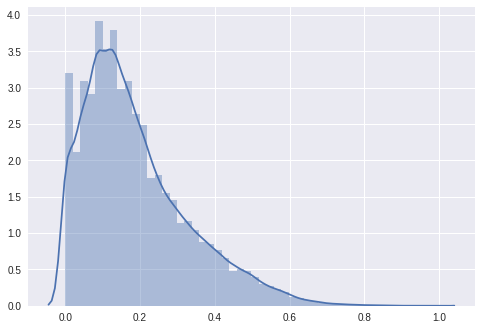

In [294]:
sns.distplot(y);

In [295]:
kde = gaussian_kde(y)

In [296]:
#probs = kde.evaluate(y)

## Build estimator for age, education, weekly income, child number, household number

In [302]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('polyno1', PolynomialFeatures(degree=3, include_bias=True)),
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0)),
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber()),
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber()),
])

est = Pipeline([
    ('union01', FeatureUnion([
        ('agetran', agetrans),
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans),
    ])),
    ('scaler', StandardScaler()),
    ('ransac', RANSACRegressor(base_estimator=Ridge(alpha=5.0),
                               random_state=42,
                               residual_threshold=0.15))
    #('ridge', Ridge(alpha=0.05))
])

In [298]:
# Grid search CV
ta = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10, 12, 15, 20, 25, 30]
gridsearch1 = GridSearchCV(est,
                          {'ransac__base_estimator__alpha': ta
                          },
                          cv=7,
                          n_jobs=-2,
                          scoring='neg_mean_squared_error',
                          verbose=True)

In [299]:
gridsearch1.fit(X, y)

Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  98 out of  98 | elapsed:   18.3s finished


GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('polyno1', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False))])), ('edutra...=None, residual_threshold=0.15, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'ransac__base_estimator__alpha': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10, 12, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [300]:
opt_alpha = gridsearch1.best_params_['ransac__base_estimator__alpha']
opt_alpha

5

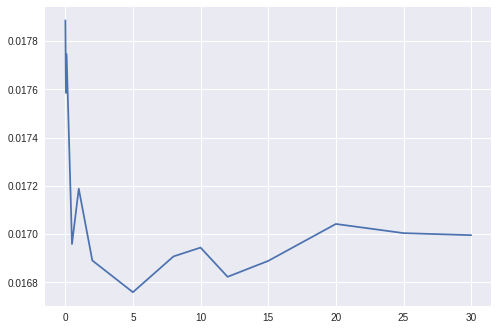

In [303]:
# Graphs
plt.plot(ta, -gridsearch1.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [304]:
est.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('polyno1', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False))])), ('edutra...=None, residual_threshold=0.15, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf))])

In [305]:
# Pickle model
joblib.dump(est, 'models/pred_model_atus_est_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_est_metric4_2017-11-01.pkl']

In [306]:
est.score(X, y)

0.15026219245215655

In [307]:
compute_mse(est, X, y, 3)

0.017128591748575946

In [308]:
est.predict(X.head(25))

array([ 0.15600834,  0.10136558,  0.12517979,  0.15301773,  0.14021838,
        0.09613603,  0.14056279,  0.33842594,  0.16292698,  0.24066259,
        0.12129371,  0.18779509,  0.14608631,  0.17531797,  0.10576238,
        0.13499611,  0.15289614,  0.12803711,  0.09349376,  0.16790059,
        0.19379666,  0.15816424,  0.1428195 ,  0.15068823,  0.27084957])

In [309]:
y[:25]

array([ 0.27777778,  0.02083333,  0.11041667,  0.10069444,  0.11458333,
        0.16319444,  0.09027778,  0.36805556,  0.20138889,  0.63194444,
        0.3125    ,  0.21875   ,  0.08333333,  0.59722222,  0.04166667,
        0.18055556,  0.15625   ,  0.33333333,  0.02083333,  0.43263889,
        0.52777778,  0.22569444,  0.21041667,  0.13888889,  0.275     ])

In [310]:
compute_mse(est, X_test, y_test, 3)

0.016241180264202303

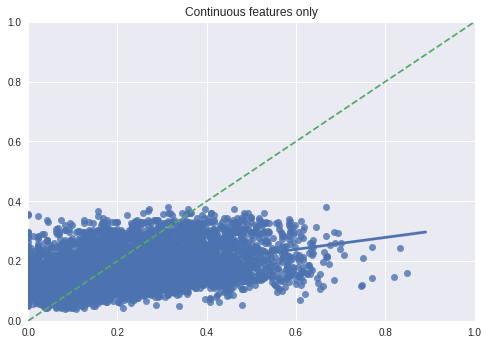

In [311]:
sns.regplot(y_test, est.predict(X_test))
plt.plot([0, 1], [0, 1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Continuous features only");

## Build estimator for all categorical features

In [312]:
# Use one-hot-encoding followed by truncated SVD to reduce feature count
est_cat = Pipeline([
    ('featse1', DataFrameSelector(feature_names=catfeatures, dtype=np.int64, ntn=True)),
    ('encode1', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('sscaler', StandardScaler()),
    ('trunsvd', TruncatedSVD(n_components=100, random_state=42)),
    ('erfregr', ExtraTreesRegressor(n_estimators=50,
                                    max_depth=8,
                                    min_samples_leaf=1,
                                    random_state=42))
])

In [313]:
# Grid search CV
tmd = [4, 6, 8, 10, 12, 15]
gridsearch_cat = GridSearchCV(est_cat,
                              {'erfregr__max_depth': tmd
                              },
                              cv=3,
                              n_jobs=-2,
                              scoring='neg_mean_squared_error',
                              verbose=True)

In [314]:
gridsearch_cat.fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'PTDTRACE', 'TRDTOCC1', 'TEIO1COW'],
         ntn=True)), ('encode1', OneHotEncoder(categorical_features='all', dtype=<type 'num..._estimators=50, n_jobs=1,
          oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'erfregr__max_depth': [4, 6, 8, 10, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [315]:
gridsearch_cat.best_params_

{'erfregr__max_depth': 8}

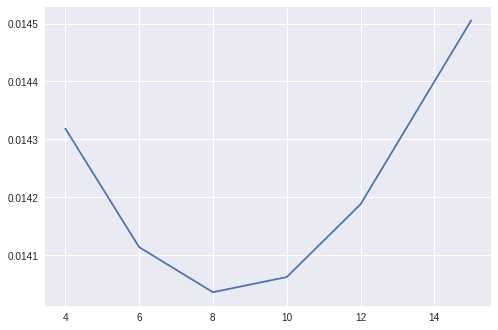

In [316]:
plt.plot(tmd, -gridsearch_cat.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [317]:
est_cat.fit(X, y)

Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'PTDTRACE', 'TRDTOCC1', 'TEIO1COW'],
         ntn=True)), ('encode1', OneHotEncoder(categorical_features='all', dtype=<type 'num..._estimators=50, n_jobs=1,
          oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [318]:
# Pickle model
joblib.dump(est_cat, 'models/pred_model_atus_catest_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_catest_metric4_2017-11-01.pkl']

In [319]:
est_cat.score(X, y)

0.32203522473708612

In [320]:
compute_mse(est_cat, X, y, 3)

0.01403598959893892

In [321]:
est_cat.predict(X.head(15))

array([ 0.13449971,  0.13770477,  0.13400459,  0.14292984,  0.11368264,
        0.10810857,  0.10722365,  0.29477617,  0.20291899,  0.31830389,
        0.13550063,  0.15336806,  0.14002191,  0.16967273,  0.1108158 ])

In [322]:
y[:15]

array([ 0.27777778,  0.02083333,  0.11041667,  0.10069444,  0.11458333,
        0.16319444,  0.09027778,  0.36805556,  0.20138889,  0.63194444,
        0.3125    ,  0.21875   ,  0.08333333,  0.59722222,  0.04166667])

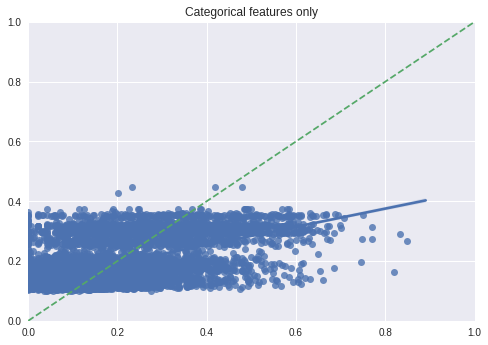

In [323]:
sns.regplot(y_test, est_cat.predict(X_test))
plt.plot([0,1], [0,1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Categorical features only");

## Combined model that uses both continuous and categorical models

In [324]:
full_est = Pipeline([
    ('union', FeatureUnion([
        ('conest', EstimatorTransformer(est)),
        ('catest', EstimatorTransformer(est_cat))
    ])),
    ('quadrat', PolynomialFeatures(degree=2, include_bias=True)),
    ('combi', LinearRegression())
])

In [325]:
full_est.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('conest', EstimatorTransformer(estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, f...ly=False)), ('combi', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [326]:
# Pickle model
joblib.dump(full_est, 'models/pred_model_atus_FULLEST_{}_{}_{}.pkl'.format(dt, m, date.today()))

['models/pred_model_atus_FULLEST_weday_metric4_2017-11-01.pkl']

In [327]:
full_est.score(X, y)

0.32577612011287804

In [328]:
compute_mse(full_est, X, y, 3)

0.013956456903280951

In [329]:
full_est.predict(X.head(15))

array([ 0.13899576,  0.12919321,  0.13126626,  0.14656941,  0.11471658,
        0.097904  ,  0.10838825,  0.31432381,  0.20682863,  0.32540672,
        0.13182431,  0.16426467,  0.14213408,  0.17732954,  0.1031579 ])

In [330]:
y[:15]

array([ 0.27777778,  0.02083333,  0.11041667,  0.10069444,  0.11458333,
        0.16319444,  0.09027778,  0.36805556,  0.20138889,  0.63194444,
        0.3125    ,  0.21875   ,  0.08333333,  0.59722222,  0.04166667])

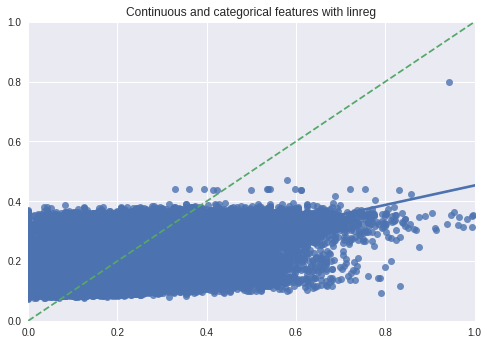

In [331]:
sns.regplot(y, full_est.predict(X))
plt.plot([0,1], [0,1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Continuous and categorical features with linreg");

## Combined model that uses the same estimator (testing only)

In [45]:
# Categorical features
cattrans_new = Pipeline([
    ('featse1', DataFrameSelector(feature_names=catfeatures, dtype=np.int64, ntn=True)),
    ('encode1', OneHotEncoder(n_values=numcats, handle_unknown='ignore')),
    ('trunsvd', TruncatedSVD(n_components=100, random_state=42))
])

# Polynominal features for age
agetrans_new = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('impute1', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler1', StandardScaler()),
    ('quadrat', PolynomialFeatures(degree=3, include_bias=False))
])

# Linear features
lintrans_new = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0))
])

# Full estimator
full_est_new = Pipeline([
    ('union', FeatureUnion([
        ('cattran', cattrans_new),
        ('agetran', agetrans_new),
        ('lintran', lintrans_new)
    ])),
    ('erfregr', ExtraTreesRegressor(n_estimators=250,
                                    max_depth=20,
                                    min_samples_leaf=1,
                                    random_state=42,
                                    n_jobs=-2))
])

In [46]:
full_est_new.fit(X, y)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('cattran', Pipeline(steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'TESCHLVL', 'PTDTRACE', 'TRMJOCGR', 'TRDTO...stimators=250, n_jobs=-2, oob_score=False, random_state=42,
          verbose=0, warm_start=False))])

In [47]:
# Pickle model
joblib.dump(full_est_new, 'models/pred_model_atus_fullestnew_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_fullestnew_metric2_2017-10-17.pkl']

In [48]:
full_est_new.score(X, y)

0.56691118179481359

In [49]:
compute_mse(full_est_new, X, y, 3)

0.0091521530124783774

In [50]:
full_est_new.predict(X.head(15))

array([ 0.49578965,  0.37962362,  0.4025354 ,  0.39310207,  0.39851097,
        0.40502732,  0.40428122,  0.47572115,  0.4192175 ,  0.4380033 ,
        0.39061039,  0.41383285,  0.48060064,  0.43854946,  0.38511133])

In [51]:
y[:15]

array([ 0.62222222,  0.33472222,  0.34375   ,  0.425     ,  0.39583333,
        0.39583333,  0.45833333,  0.40972222,  0.31388889,  0.26388889,
        0.375     ,  0.37152778,  0.68055556,  0.40277778,  0.39583333])

In [52]:
compute_mse(full_est_new, X_test, y_test, 3)

0.0094425956987346429

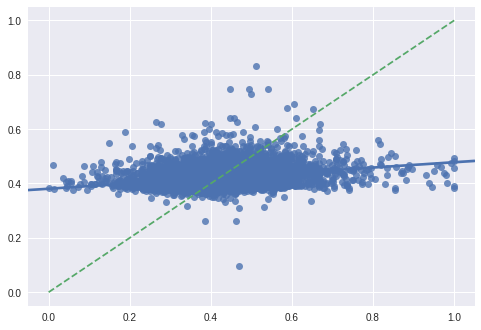

In [74]:
sns.regplot(y_test, y_test - full_est_new.predict(X_test))
plt.axis([0, 1, 0, 1])
plt.plot([0,1], [0,1], ls='--');

In [38]:
dfindcodes

,FLAG,CODE,NAME
0,TRDTOCC1,1,Management occupations
1,TRDTOCC1,2,Business and financial operations occupations
2,TRDTOCC1,3,Computer and mathematical science occupations
3,TRDTOCC1,4,Architecture and engineering occupations
4,TRDTOCC1,5,"Life, physical, and social science occupations"
5,TRDTOCC1,6,Community and social service occupations
6,TRDTOCC1,7,Legal occupations
7,TRDTOCC1,8,"Education, training, and library occupations"
8,TRDTOCC1,9,"Arts, design, entertainment, sports, and media..."
9,TRDTOCC1,10,Healthcare practitioner and technical occupations
